<h1 id="tocheading">1. CAPÍTULO II. Un Pequeño ejemplo de Visualización</h1>
<div id="toc"></div> 

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
# !pip install tables
# !pip install plotly

In [3]:
# Declare inline graphics
%matplotlib inline

In [4]:
# Celda de preparación -- ejecutar siempre
from __future__ import print_function, division

In [5]:
import sys
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import seaborn as sns

import warnings
import psycopg2
from sqlalchemy import create_engine

In [6]:
# Initialize the plotting space
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = 16, 6;
plt.rcParams['figure.facecolor'] = 'white';

In [ ]:
# Evitar la aparición de warnings
# Ignorar una advertencia específica por su categoría
# warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
# Indicar Ubicación de la Carpeta de imágenes
# jupyter Notebook
url_tablas = r'C:\\Temp\\tablas\\'

# 2. Análisis de los datos. (un ejemplo)

## 2.1. Tabla 1- Parámetros de Edificabilidad por Parcela.

In [8]:
# Carga de la tabla
archivo_csv = 't01_edificab_parcel.csv'

ruta_archivo = url_tablas + archivo_csv

# Cargar el archivo CSV en un DataFrame de pandas
df_01 = pd.read_csv(ruta_archivo)

# Muestra las primeras filas del DataFrame
df_01.head()

,pc_31,sup_construida,sup_parcela,ind_edificab,sup_viv,porc_uso_viv
0,4956602UG4945N,1285.0,55,23.3636,1285.0,100.00
1,3863701UG4936S,3793.0,232,16.3491,832.0,21.94
2,3647616UG4934N,730.0,64,11.4063,658.0,90.14
3,3349201UG4934N,8563.0,842,10.1698,0.0,0.00
4,3647621UG4934N,1166.0,115,10.1391,909.0,77.96


**Descripción de los campos:**
|columna|descripción
| :- | :------------- |
|**`sup_construida`**|superficie construida por cada parcela
|**`sup_parcela`**|superficie de la parcela
|**`ind_edificab`**|Indice de edificabilidad = sup_construida/sup_parcela
|**`sup_viv`**|superficie construida de uso vivienda
|**`porc_uso_viv`**|porcentaje de superficie de uso vivienda sobre el total de la superficie construida

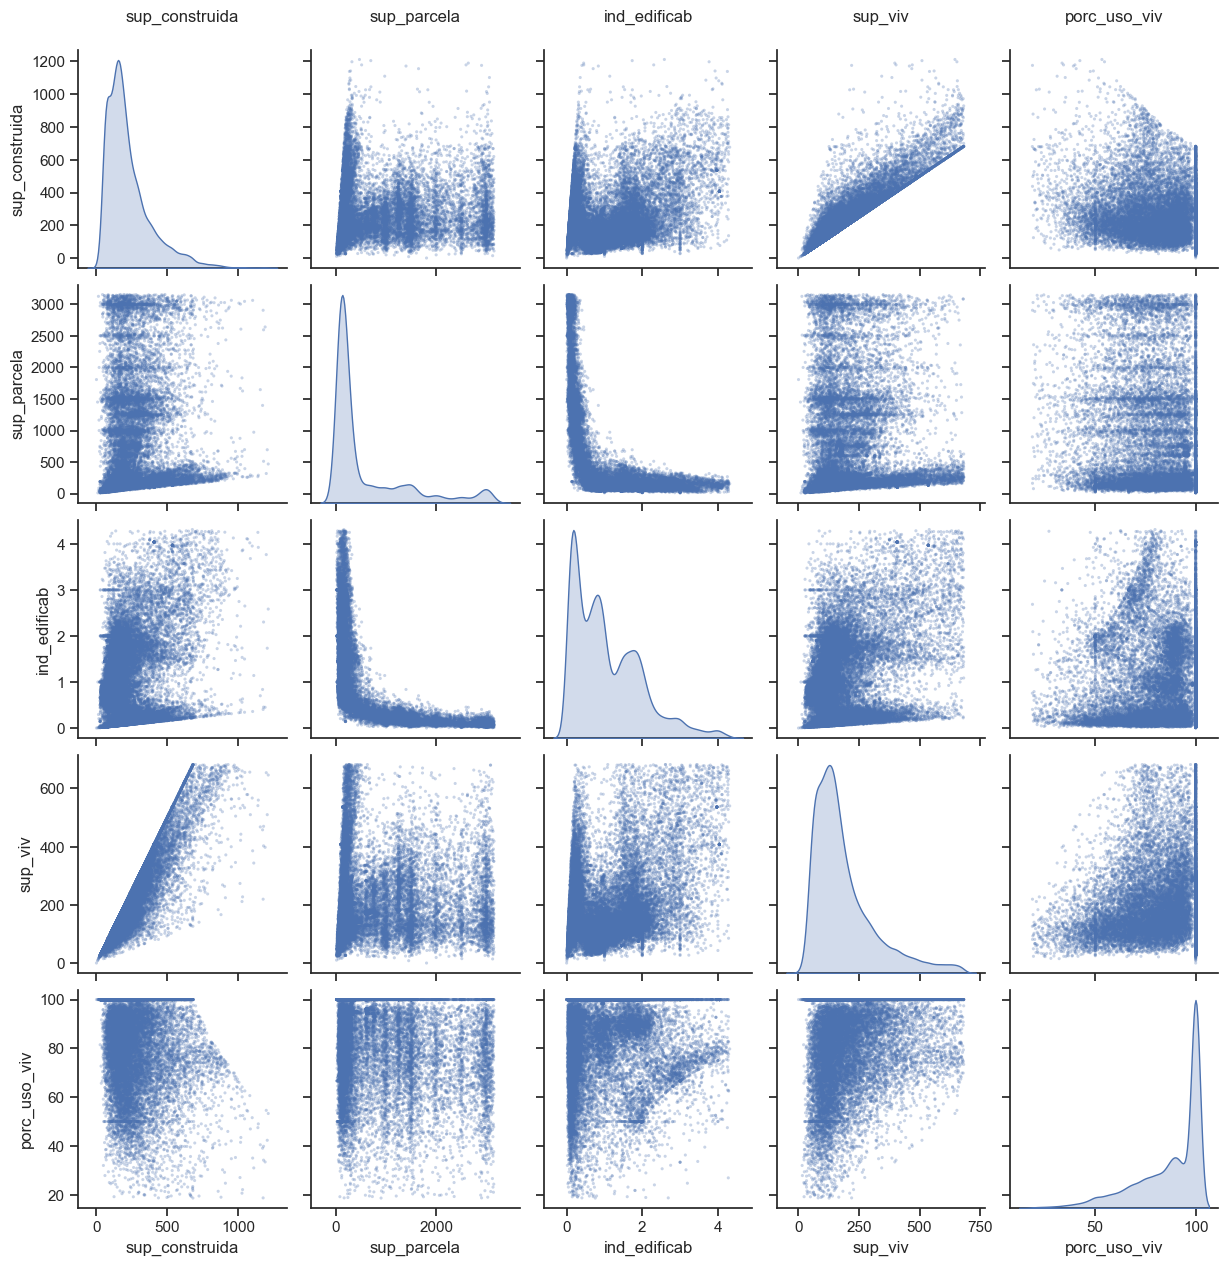

In [9]:
# GRÁFICO DE t01_edificabilidad. ELIMINANDO OUTLIERS

# Selecciona las columnas relevantes del DataFrame
lista_columnas = ['sup_construida', 'sup_parcela', 'ind_edificab', 'sup_viv', 'porc_uso_viv']

# Define el rango intercuartílico (IQR) para detectar outliers
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers

# Detecta outliers en cada columna
outliers = df_01[lista_columnas].apply(find_outliers)

# Filtra los datos para eliminar outliers
filtered_data = df_01[~outliers.any(axis=1)]

# Define los parámetros para los puntos de dispersión
scatter_kws = {'alpha': 0.3,
               's': 5,
               'edgecolor': 'none'}

# Crea la matriz de gráficos de dispersión con los parámetros personalizados
sns.set(style="ticks")
g = sns.pairplot(filtered_data[lista_columnas],
                 diag_kind='kde',
                 markers='o',
                 plot_kws=scatter_kws)

# Agregar etiquetas en la parte superior de cada columna
for i, col in enumerate(lista_columnas):
    g.axes[0, i].set_title(col, fontsize=12, pad=20)

# Mostrar la matriz
plt.show()

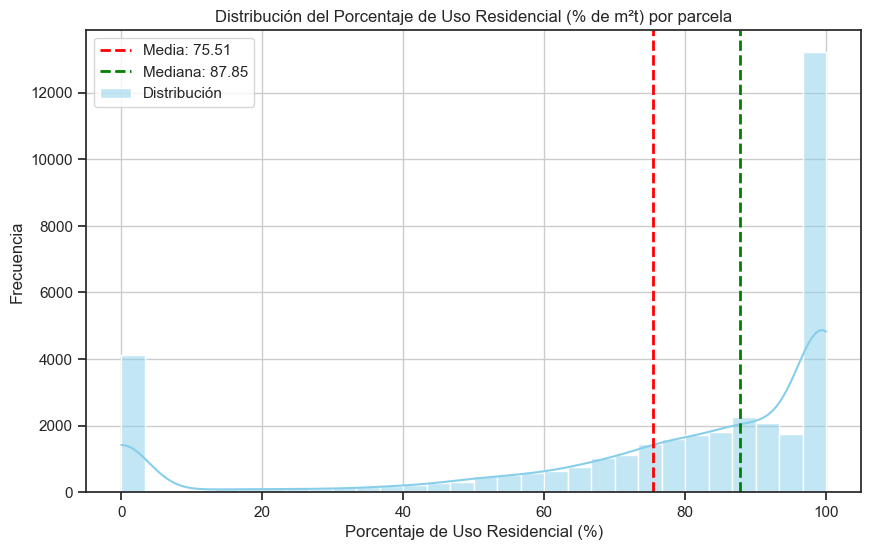

In [10]:
# Calcular el histograma de porc_uso_viv
plt.figure(figsize=(10, 6))
sns.histplot(df_01['porc_uso_viv'], bins=30, kde=True, color='skyblue', label='Distribución')

# Configurar etiquetas y título
plt.xlabel('Porcentaje de Uso Residencial (%)')
plt.ylabel('Frecuencia')
plt.title('Distribución del Porcentaje de Uso Residencial (% de m²t) por parcela')

# Agregar una línea vertical para la media
media = df_01['porc_uso_viv'].mean()
plt.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Media: {media:.2f}')

# Agregar una línea vertical para la mediana
mediana = df_01['porc_uso_viv'].median()
plt.axvline(mediana, color='green', linestyle='dashed', linewidth=2, label=f'Mediana: {mediana:.2f}')

# Agregar una leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

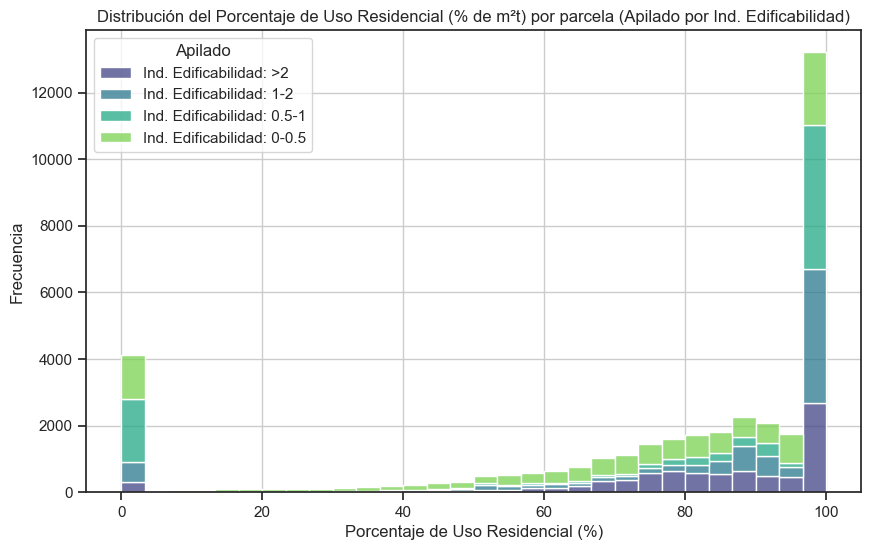

In [11]:
# Crear una paleta de colores personalizada en orden inverso
# Definir los límites para los grupos de ind_edificab
bins = [0, 0.5, 1, 2, float('inf')]
labels = ['>2', '1-2', '0.5-1', '0-0.5']

# Agregar la columna de grupos a df_01
df_01['ind_edificab_group'] = pd.cut(df_01['ind_edificab'], bins=bins, labels=labels)

# Crear una paleta de colores personalizada en orden inverso
custom_palette = sns.color_palette("viridis", n_colors=len(labels))[::-1]

# Crear un histograma apilado con Seaborn y desactivar la leyenda predeterminada
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_01,
                  x='porc_uso_viv',
                  hue='ind_edificab_group',
                  multiple='stack',
                  bins=30,
                  palette=custom_palette, legend=False)

# Configurar etiquetas y título
plt.xlabel('Porcentaje de Uso Residencial (%)')
plt.ylabel('Frecuencia')
plt.title('Distribución del Porcentaje de Uso Residencial (% de m²t) por parcela (Apilado por Ind. Edificabilidad)')

# Crear una leyenda personalizada
legend_labels = [f'Ind. Edificabilidad: {label}' for label in labels]

# Agregar leyenda personalizada
plt.legend(legend_labels, title='Apilado')

# Mostrar el gráfico
plt.grid(True)
plt.show()

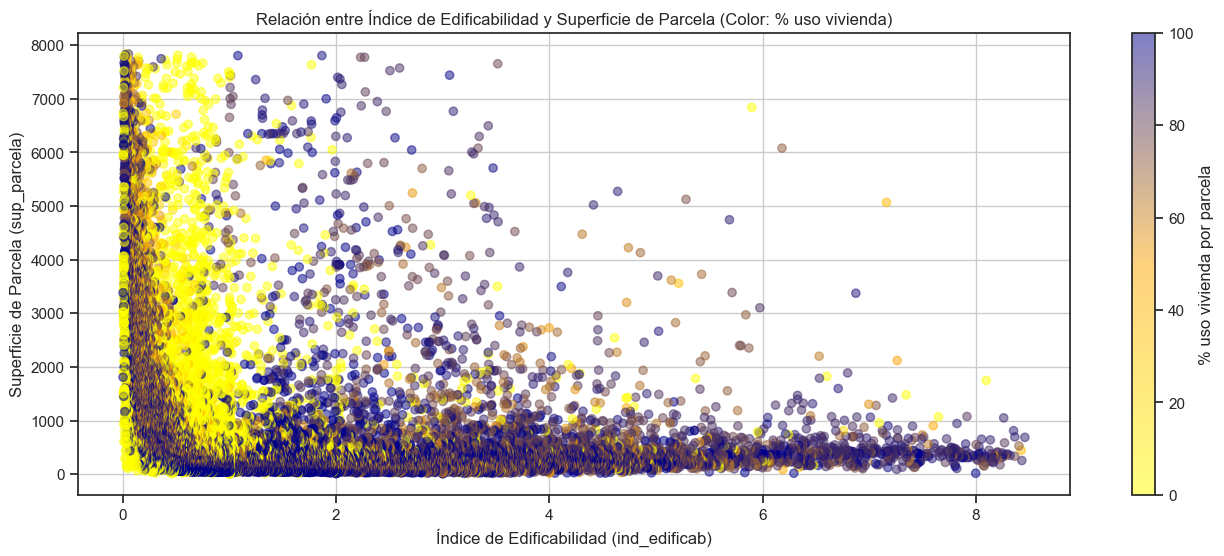

In [12]:
# Crear una escala de colores personalizada con un color intermedio (por ejemplo, naranja)
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom', [(0, 'yellow'),
                                                                   (0.5, 'orange'),
                                                                   (1, 'darkblue')])

# Función para identificar y eliminar outliers usando el método IQR
def remove_rango(df, column):
    Q1 = df[column].quantile(0.10)
    Q3 = df[column].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Eliminar outliers en las columnas relevantes
df_01 = remove_rango(df_01, 'ind_edificab')
df_01 = remove_rango(df_01, 'sup_parcela')
df_01 = remove_rango(df_01, 'porc_uso_viv')

# Crear un gráfico de dispersión con histogramas marginales
fig, ax = plt.subplots()
scatter = ax.scatter(
    df_01['ind_edificab'],  # Usar ind_edificab en el eje X
    df_01['sup_parcela'],  # Usar sup_parcela en el eje Y
    c=df_01['porc_uso_viv'],  # Asignar color en función de porc_uso_viv
    cmap=cmap_custom,  # Usar la escala de colores personalizada
    alpha=0.5,  # Ajustar la transparencia (alpha) de los puntos
)

# Configurar etiquetas y título
plt.xlabel('Índice de Edificabilidad (ind_edificab)')
plt.ylabel('Superficie de Parcela (sup_parcela)')
plt.title('Relación entre Índice de Edificabilidad y Superficie de Parcela (Color: % uso vivienda)')
plt.colorbar(scatter, label='% uso vivienda por parcela')  # Agregar barra de colores con etiqueta

# Mostrar el gráfico
plt.grid(True)
plt.show()